In [1]:
import math
import numpy as np
import os
import random
import shutil
import time
from matplotlib import pyplot as plt
from easydict import EasyDict
from PIL import Image

import mindspore as ms
from mindspore import context
from mindspore import nn
from mindspore import Tensor
from mindspore.train.model import Model
from mindspore.train.serialization import load_checkpoint, save_checkpoint, export
from mindspore.train.callback import Callback, LossMonitor, ModelCheckpoint, CheckpointConfig

from dataset import create_dataset # 数据处理脚本
from mobilenetV3 import mobilenet_v3_large, MobileNetV3Head, mobilenet_v3 # 模型定义脚本

os.environ['GLOG_v'] = '3' # Log level includes 3(ERROR), 2(WARNING), 1(INFO), 0(DEBUG).
context.set_context(mode=context.GRAPH_MODE, device_target="CPU") # 设置采用图模式执行，设备为Ascend# 


In [2]:
# 垃圾分类数据集标签，以及用于标签映射的字典。
garbage_classes = {
    '干垃圾': ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服'],
    '可回收物': ['报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张'],
    '湿垃圾': ['菜叶', '橙皮', '蛋壳', '香蕉皮'],
    '有害垃圾': ['电池', '药片胶囊', '荧光灯', '油漆桶']
}

class_cn = ['贝壳', '打火机', '旧镜子', '扫把', '陶瓷碗', '牙刷', '一次性筷子', '脏污衣服',
            '报纸', '玻璃制品', '篮球', '塑料瓶', '硬纸板', '玻璃瓶', '金属制品', '帽子', '易拉罐', '纸张',
            '菜叶', '橙皮', '蛋壳', '香蕉皮',
            '电池', '药片胶囊', '荧光灯', '油漆桶']
class_en = ['Seashell', 'Lighter','Old Mirror', 'Broom','Ceramic Bowl', 'Toothbrush','Disposable Chopsticks','Dirty Cloth',
            'Newspaper', 'Glassware', 'Basketball', 'Plastic Bottle', 'Cardboard','Glass Bottle', 'Metalware', 'Hats', 'Cans', 'Paper',
            'Vegetable Leaf','Orange Peel', 'Eggshell','Banana Peel',
            'Battery', 'Tablet capsules','Fluorescent lamp', 'Paint bucket']

index_en = {'Seashell': 0, 'Lighter': 1, 'Old Mirror': 2, 'Broom': 3, 'Ceramic Bowl': 4, 'Toothbrush': 5, 'Disposable Chopsticks': 6, 'Dirty Cloth': 7,
            'Newspaper': 8, 'Glassware': 9, 'Basketball': 10, 'Plastic Bottle': 11, 'Cardboard': 12, 'Glass Bottle': 13, 'Metalware': 14, 'Hats': 15, 'Cans': 16, 'Paper': 17,
            'Vegetable Leaf': 18, 'Orange Peel': 19, 'Eggshell': 20, 'Banana Peel': 21,
            'Battery': 22, 'Tablet capsules': 23, 'Fluorescent lamp': 24, 'Paint bucket': 25}

# 训练超参
config = EasyDict({
    "num_classes": 26,
    "image_height": 224,
    "image_width": 224,
    #"data_split": [0.9, 0.1],
    "backbone_out_channels":1280,
    "batch_size": 64,
    "eval_batch_size": 8,
    "epochs": 10,
    "lr_max": 0.05,
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "save_ckpt_epochs": 1,
    "save_ckpt_path": "./ckpt",
    "dataset_path": "./data_en",
    "class_index": index_en,
    "pretrained_ckpt": "./mobilenetV2-200_1067.ckpt" # mobilenetV2-200_1067.ckpt mobilenetv2_ascend.ckpt
})


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


32


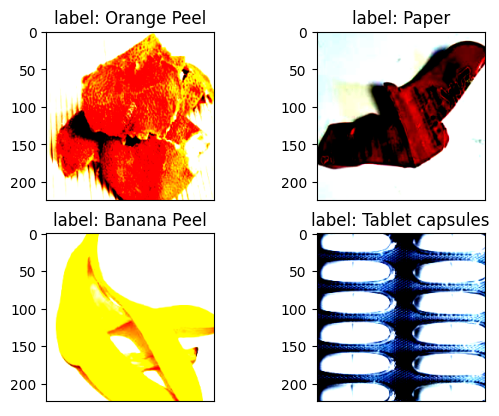

In [3]:
ds = create_dataset(dataset_path=config.dataset_path, config=config, training=False)
print(ds.get_dataset_size())
data = ds.create_dict_iterator(output_numpy=True)._get_next()
images = data['image']
labels = data['label']

for i in range(1, 5):
    plt.subplot(2, 2, i)
    plt.imshow(np.transpose(images[i], (1,2,0)))
    plt.title('label: %s' % class_en[labels[i]])
    plt.xticks([])
plt.show()


In [4]:
def cosine_decay(total_steps, lr_init=0.0, lr_end=0.0, lr_max=0.1, warmup_steps=0):
    """
    Applies cosine decay to generate learning rate array.

    Args:
       total_steps(int): all steps in training.
       lr_init(float): init learning rate.
       lr_end(float): end learning rate
       lr_max(float): max learning rate.
       warmup_steps(int): all steps in warmup epochs.

    Returns:
       list, learning rate array.
    """
    lr_init, lr_end, lr_max = float(lr_init), float(lr_end), float(lr_max)
    decay_steps = total_steps - warmup_steps
    lr_all_steps = []
    inc_per_step = (lr_max - lr_init) / warmup_steps if warmup_steps else 0
    for i in range(total_steps):
        if i < warmup_steps:
            lr = lr_init + inc_per_step * (i + 1)
        else:
            cosine_decay = 0.5 * (1 + math.cos(math.pi * (i - warmup_steps) / decay_steps))
            lr = (lr_max - lr_end) * cosine_decay + lr_end
        lr_all_steps.append(lr)

    return lr_all_steps


In [5]:
def switch_precision(net, data_type):
    if context.get_context('device_target') == "Ascend":
        net.to_float(data_type)
        for _, cell in net.cells_and_names():
            if isinstance(cell, nn.Dense):
                cell.to_float(ms.float32)


In [6]:
class EvalCallback(Callback):
    def __init__(self, model, eval_dataset, history, eval_epochs=1):
        self.model = model
        self.eval_dataset = eval_dataset
        self.eval_epochs = eval_epochs
        self.history = history
        self.acc_max = 0
        # acc连续5次<=过程中的最大值，则停止训练
        self.count_max = 5
        self.count = 0
    
    def epoch_begin(self, run_context):
        self.losses = []
        self.startime = time.time()
  
    def step_end(self, run_context):
        cb_param = run_context.original_args()
        loss = cb_param.net_outputs
        self.losses.append(loss.asnumpy())
    
    def epoch_end(self, run_context):
        cb_param = run_context.original_args()
        cur_epoch = cb_param.cur_epoch_num
        train_loss = np.mean(self.losses)
        time_cost = time.time() - self.startime
        if cur_epoch % self.eval_epochs == 0:
            metric = self.model.eval(self.eval_dataset, dataset_sink_mode=False)
            self.history["epoch"].append(cur_epoch)
            self.history["eval_acc"].append(metric["acc"])
            self.history["eval_loss"].append(metric["loss"])
            self.history["train_loss"].append(train_loss)
            self.history["time_cost"].append(time_cost)
            if self.acc_max < metric["acc"]:
                self.count = 0
                self.acc_max = metric["acc"]
            else:
                self.count += 1
                if self.count == self.count_max:
                    run_context.request_stop()
            print("epoch: %d, train_loss: %f, eval_loss: %f, eval_acc: %f, time_cost: %f" %(cur_epoch, train_loss, metric["loss"], metric["acc"], time_cost))


In [7]:
from mindspore.train.loss_scale_manager import FixedLossScaleManager
LOSS_SCALE = 1024
def train():
    train_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    eval_dataset = create_dataset(dataset_path=config.dataset_path, config=config)
    step_size = train_dataset.get_dataset_size()
    
    backbone = mobilenet_v3_large() #last_channel=config.backbone_out_channels
    # Freeze parameters of backbone. You can comment these two lines.
    for param in backbone.get_parameters():
       param.requires_grad = False
    # load parameters from pretrained model
    # load_checkpoint(config.pretrained_ckpt, backbone)

    # head = MobileNetV2Head(num_classes=config.num_classes, last_channel=config.backbone_out_channels)
    head = MobileNetV3Head(num_classes=config.num_classes)
    network = mobilenet_v3(backbone, head)

    # define loss, optimizer, and model
    loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
    loss_scale = FixedLossScaleManager(LOSS_SCALE, drop_overflow_update=False)
    lrs = cosine_decay(config.epochs * step_size, lr_max=config.lr_max)
    opt = nn.Momentum(network.trainable_params(), lrs, config.momentum, config.weight_decay, loss_scale=LOSS_SCALE)
    model = Model(network, loss, opt, loss_scale_manager=loss_scale, metrics={'acc', 'loss'})

    history = {'epoch': [], 'train_loss': [], 'eval_loss': [], 'eval_acc': [], 'time_cost':[]}
    eval_cb = EvalCallback(model, eval_dataset, history)
    cb = [eval_cb]
    ckpt_cfg = CheckpointConfig(save_checkpoint_steps=config.save_ckpt_epochs * step_size, keep_checkpoint_max=config.epochs)
    ckpt_cb = ModelCheckpoint(prefix="mobilenetv2", directory=config.save_ckpt_path, config=ckpt_cfg)
    cb.append(ckpt_cb)
    model.train(50, train_dataset, callbacks=cb, dataset_sink_mode=False)
    
    return history


In [8]:
if os.path.exists(config.save_ckpt_path):
    shutil.rmtree(config.save_ckpt_path)

history = train()

plt.plot(history['epoch'], history['train_loss'], label='train_loss')
plt.plot(history['epoch'], history['eval_loss'], 'r', label='val_loss')
plt.legend()
plt.show()

plt.plot(history['epoch'], history['eval_acc'], 'r', label = 'val_acc')
plt.legend()
plt.show()

CKPT = 'mobilenetv2-%d_40.ckpt' % (np.argmax(history['eval_acc']) + 1) # 挑选最优模型Checkpoint，根据数据量和batch_size修改81值
print("Chosen checkpoint is", CKPT)


[WARNING] ME(3964:592,MainProcess):2022-09-10-12:20:46.223.908 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(3964:592,MainProcess):2022-09-10-12:20:46.274.627 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(3964:592,MainProcess):2022-09-10-12:20:46.341.429 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(3964:592,MainProcess):2022-09-10-12:20:46.374.850 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(3964:592,MainProcess):2022-09-10-12:20:46.421.033 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add'

KeyboardInterrupt: 

In [ ]:
# CKPT="mobilenetv2-11_40.ckpt"

In [ ]:
def image_process(image):
    """Precess one image per time.
    
    Args:
        image: shape (H, W, C)
    """
    mean=[0.485*255, 0.456*255, 0.406*255]
    std=[0.229*255, 0.224*255, 0.225*255]
    image = (np.array(image) - mean) / std
    image = image.transpose((2,0,1))
    img_tensor = Tensor(np.array([image], np.float32))
    return img_tensor

def infer_one(network, image_path):
    image = Image.open(image_path).resize((config.image_height, config.image_width))
    logits = network(image_process(image))
    pred = np.argmax(logits.asnumpy(), axis=1)[0]
    print(image_path, class_en[pred])

def infer():
    backbone = mobilenet_v3_large()
    head = MobileNetV3Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
    network = mobilenet_v3(backbone, head)
    load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), network)
    for i in range(91, 100):
        infer_one(network, f'data_en/test/Cardboard/000{i}.jpg')
infer()


[WARNING] ME(6569:281472910342448,MainProcess):2021-05-08-08:30:14.941.10 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(6569:281472910342448,MainProcess):2021-05-08-08:30:14.127.949 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(6569:281472910342448,MainProcess):2021-05-08-08:30:14.161.271 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(6569:281472910342448,MainProcess):2021-05-08-08:30:14.194.802 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(6569:281472910342448,MainProcess):2021-05-08-08:30:14.227.845 [mindspore/ops/operations/math_ops.py:171] WARN_DEPRECATED: The usage of TensorAdd is deprecated. Please use Add.
[WARNING] ME(6569:281472910342448,MainProcess):2021-05-0

data_en/test/Cardboard/00091.jpg Cardboard
data_en/test/Cardboard/00092.jpg Cardboard
data_en/test/Cardboard/00093.jpg Cardboard
data_en/test/Cardboard/00094.jpg Cardboard
data_en/test/Cardboard/00095.jpg Cardboard
data_en/test/Cardboard/00096.jpg Cardboard
data_en/test/Cardboard/00097.jpg Cardboard
data_en/test/Cardboard/00098.jpg Cardboard
data_en/test/Cardboard/00099.jpg Cardboard


In [ ]:
backbone = mobilenet_v3_large()
head = MobileNetV3Head(input_channel=backbone.out_channels, num_classes=config.num_classes)
network = mobilenet_v3(backbone, head)
load_checkpoint(os.path.join(config.save_ckpt_path, CKPT), network)

input = np.random.uniform(0.0, 1.0, size=[1, 3, 224, 224]).astype(np.float32)
export(network, Tensor(input), file_name='mobilenetv2.air', file_format='AIR') # MindSpore 1.0
# export(network, Tensor(input), file_name='mobilenetv2.pb', file_format='GEIR') # MindSpore 0.5
# export(network, Tensor(input), file_name='mobilenetv2.onnx', file_format='ONNX')
#添加一行代码导出mindir模型，用于手机端
export(network, Tensor(input), file_name='mobilenetv2', file_format='MINDIR') 

[WARNING] ME(15368:8540,MainProcess):2022-09-09-12:57:48.111.241 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(15368:8540,MainProcess):2022-09-09-12:57:48.143.157 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(15368:8540,MainProcess):2022-09-09-12:57:48.174.298 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(15368:8540,MainProcess):2022-09-09-12:57:48.208.224 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version, use 'Add' instead.
[WARNING] ME(15368:8540,MainProcess):2022-09-09-12:57:48.241.951 [mindspore\common\_decorator.py:33] 'TensorAdd' is deprecated from version 1.1 and will be removed in a future version,

NameError: name 'CKPT' is not defined